# lab3 - Levenshtein distance and spelling corrections

The task introduces the Levenshtein distance - a measure that is useful in tasks such as approximate string matching.

In [1]:
from elasticsearch import Elasticsearch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from itertools import chain
import Levenshtein as lev
from typing import Dict

In [2]:
es = Elasticsearch()

## Tasks

1. Use ElasticSearch term vectors API to retrieve and store for each document the following data:
   1. The terms (tokens) that are present in the document.
   2. The number of times given term is present in the document.
   

In [3]:
indices = [h["_id"] for h in es.search(
    index="przewie",
    doc_type="act",
    body={
        "query": {
            "match_all": {}
            }
        },
    size=2000
)["hits"]["hits"]]

In [4]:
result = {
    i: {
        token: metadata["term_freq"]
        for token, metadata in es.termvectors("przewie", "act", i, term_statistics=True, fields=["text"])["term_vectors"]["text"]["terms"].items()
    }
    for i in indices
}
result;

2. Aggregate the result to obtain one global **frequency list**.

In [5]:
global_result = {}

for r in result.values():
    for token, freq in r.items():
        global_result[token] = global_result.get(token, 0) + freq

global_result;

3. Filter the list to keep terms that contain only letters and have at least 2 of them.

In [6]:
filtered_result = {
    k: v 
    for k, v in global_result.items()
    if len(k) > 2 and k.isalpha()
}

filtered_result;

4. Make a plot in a logarithmic scale:
   1. X-axis should contain the **rank** of a term, meaning the first rank belongs to the term with the highest number of
      occurrences; the terms with the same number of occurrences should be ordered by their name,
   2. Y-axis should contain the **number of occurrences** of the term with given rank.
   

In [7]:
sorted_result = sorted(filtered_result.items(), key = lambda r: -r[1])

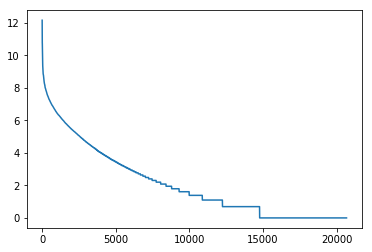

In [8]:
plt.plot(list(range(len(sorted_result))), [np.log(r[1]) for r in sorted_result])

5. Download [polimorfologik.zip](https://github.com/morfologik/polimorfologik/releases/download/2.1/polimorfologik-2.1.zip) dictionary
   and use it to find all words that do not appear in that dictionary.
   

In [9]:
with Path("../data/polimorfologik/polimorfologik-2.1.txt").open() as f:
    polimorf = [l.split(";")[0:2] for l in f.readlines()]

In [10]:
words = set(chain.from_iterable(polimorf))

In [11]:
unknowns = {k:v for k,v in filtered_result.items() if k not in words}
unknowns.keys();

6. Find 30 words with the highest ranks that do not belong to the dictionary.

In [12]:
[r for r in sorted_result if r[0] not in words][:30]

[('margin', 1111),
 ('późn', 1080),
 ('family', 543),
 ('text', 529),
 ('mso', 448),
 ('bottom', 399),
 ('face', 326),
 ('panose', 326),
 ('serif', 319),
 ('GMO', 298),
 ('Times', 296),
 ('name', 254),
 ('size', 248),
 ('left', 233),
 ('right', 233),
 ('SWW', 227),
 ('SKW', 196),
 ('height', 168),
 ('line', 168),
 ('IKE', 162),
 ('indent', 121),
 ('remediacji', 120),
 ('VII', 111),
 ('URE', 101),
 ('UKE', 97),
 ('PKWiU', 81),
 ('UDT', 77),
 ('podw', 77),
 ('VIII', 72),
 ('BSWSG', 70)]

7. Find 30 words with 3 occurrences that do not belong to the dictionary.

In [13]:
unknowns_with_three_occurences = [r for r in sorted_result if r[0] not in words and r[1] == 3 ][:30]
unknowns_with_three_occurences;

8. Use Levenshtein distance and the frequency list, to determine the most probable correction of the words from the
   second list.

In [14]:
knowns = {k:v for k,v in filtered_result.items() if k in words}

In [15]:
def probable_correction(word: str, frequency_dict: Dict[str, int]) -> str:
    return sorted(frequency_dict.keys(), key=lambda key: -np.log(frequency_dict[key]) / lev.distance(word, key))[0]

In [16]:
{
    w[0] : probable_correction(w[0], knowns)
    for w in unknowns_with_three_occurences
}

{'ności': 'ilości',
 'publicz': 'publiczny',
 'rytorialnego': 'terytorialny',
 'szczegól': 'szczególny',
 'terytorial': 'terytorialny',
 'trzeżeniem': 'brzmienie',
 'ubezpiecze': 'ubezpieczyć',
 'zacją': 'zająć',
 'zania': 'dana',
 'zas': 'czas',
 'świad': 'wiek',
 'żetowych': 'który',
 'cych': 'cech',
 'winopodobne': 'wiek',
 'winopodobnych': 'wiek',
 'cidr': 'wiek',
 'gigadżul': 'wiek',
 'oszczędnościowokredytowych': 'ojciec',
 'pra': 'gra',
 'biorównoważności': 'równowartość',
 'protokoł': 'protokół',
 'jeeli': 'jeżeli',
 'szkolnowychowawczym': 'wychowawczy',
 'zadrzewieniach': 'brzmienie',
 'asistent': 'asystent',
 'medical': 'medal',
 'XXXVI': 'wiek',
 'wypożyczeń': 'pozycja',
 'instrumentalistyki': 'numer',
 'EUTC': 'wiek'}

## Hints

1. Levenshtein distance (Edit distance) is a measure defined for any pair of strings. It is defined as the minimal
   number of single character edits (insertions, deletions or substitutions) needed to transform one string to the
   other. The measure is symmetric.
1. The algorithm is usually implemented as a dynamic program, see [Wikipedia article](https://en.wikipedia.org/wiki/Levenshtein_distance) 
   for details.
1. The distance may be used to fix an invalid word by inspecting in the growing order of the distance, the words
   that are *n* edits away from the invalid word. If there are no words *n* edits away, the words *n+1* edits away 
   are inspected.
1. The frequency list may be used to select the most popular word with given distance, if there are many candidate
   corrections.
1. Usually the correction algorithm does not use the edit distance directly, since it would require to compare the
   invalid word with all words in the dictionary. The algorithms work in the opposite way - the generate candidate words
   that are 1 or 2 edits away from the invalid word (cf. P. Norvigs [article](https://norvig.com/spell-correct.html) 
   for the details). A different approach is to use [Levenshtein automaton](https://norvig.com/spell-correct.html) for
   finding the corrections effectively.
1. ElasticSearch has a [fuzziness](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-fuzzy-query.html)
   parameter for finding approximate matches of a query.